## Mix of pipeline from pyimagesearch and keras MNIST example/tutorial(s)
* Codes taken from:
    
    * https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
    * https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
* Added explainations as per my own understanding. 
* Cited resources wherever possible.

#### What more can be added?

- Implement a module/detector which can take a video/camera feed, able to localize and identify digits.

@anujonthemove

## Imports

In [1]:
# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
# part of keras util to load mnist dataset
# from keras.datasets import mnist

# scikit-learn
from sklearn import datasets
from sklearn.cross_validation import train_test_split

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import os

/home/anuj/.virtualenvs/video-analytics-2/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/anuj/.virtualenvs/video-analytics-2/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Network parameters

In [2]:
batch_size = 128
num_classes = 10
epochs = 20
img_rows, img_cols = (28, 28)

## Class - for network architecture

In [3]:
class LeNet(object):
       
    @staticmethod
    def pyimagesearch_build(input_shape, num_classes, weightsPath=None):
        model = Sequential()
        
        # first: conv => relu => pool
        model.add(Conv2D(20, 5, 5, input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second: conv => relu => pool
        model.add(Conv2D(50, 5, 5))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
                
        # flatten - convert matrix to 1d vector
        # till here we have all the features ready in a vector
        model.add(Flatten())
        
        # The output from the convolutional layers represents high-level features in the data. 
        # While that output could be flattened and connected to the output layer, 
        # adding a fully-connected layer is a (usually) cheap way of learning 
        # non-linear combinations of these features.
        # Essentially the convolutional layers are providing a meaningful, 
        # low-dimensional, and somewhat invariant feature space, 
        # and the fully-connected layer is learning a (possibly non-linear) function in that space.
        # https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns
        model.add(Dense(500))
        model.add(Activation('relu')) # - this is responsible for the non-linearity
        
        # outout layer with softmax classifier
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)

        # return the constructed network architecture
        return model

    @staticmethod
    def keras_build(input_shape, num_classes, weightsPath=None):
        model = Sequential()

        # first
        model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second
        model.add(Conv2D(64, kernel_size=(3, 3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))

        model.add(Dropout(0.5))

        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        # if a weights path is supplied (inicating that the model was
        # pre-trained), then load the weights
        if weightsPath is not None:
            model.load_weights(weightsPath)

        # return the constructed network architecture
        return model


## Class - for getting data and model building

In [4]:
class Preprocess(object):
    
    @staticmethod
    def prepare_data(num_classes):
    
        input_shape = None

        # 1. get dataset using scikit learn util
        dataset = datasets.fetch_mldata("MNIST Original")
        print("Downloaded dataset shape: " + str(dataset.data.shape))

        # Alternative to scikit is keras own util: 
        # loads train and test data using keras utils- uncomment corresponding import
        # the data is already split between train and test sets
        # (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # 2. Important step: check what backend is being used, using that info get the input shape
        # to be given to the model(api per say)
        if K.image_data_format() == 'channels_first':
            # X(not y)
            data = dataset.data.reshape(dataset.data.shape[0], 1, img_rows, img_cols)
            # here 1 is because we have a single channel grayscale image
            input_shape = (1, img_rows, img_cols)
        else:
            data = dataset.data.reshape(dataset.data.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)


        # 3. split data into training and test sets - 77% and 33% respectively
        #  scaled data(X) between 0 and 1 / reduce images from the range [0, 255] to [0, 1.0], 
        # it is a common scaling technique - divide by 255.0
        # represented/converted the target(y) to integer
        (x_train, x_test, y_train, y_test) = train_test_split(data/255.0, 
                                                              dataset.target.astype("int"), test_size=0.33)

        # 4. Keras takes in the data type as float32, hence this step
        # https://stackoverflow.com/questions/38066307/how-to-training-testing-without-make-all-of-the-data-float32-in-keras
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        # do this if not already done above.
        # x_train /= 255
        # x_test /= 255

        # 5. convert categorical data to one hot encoded vector  
        # convert class vectors to binary class matrices - one hot encoding
        # np.utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
        # https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        print('x_train shape:', x_train.shape)
        print(x_train.shape[0], 'train samples')
        print(x_test.shape[0], 'test samples')
        print('input_shape: ' + str(input_shape))
        return x_train, x_test, y_train, y_test, input_shape

    
    @staticmethod
    def get_model(input_shape, num_classes, weightsPath, save_model=True, arch_type='keras'):
    
        # 1. initialize architecture
        if arch_type == 'keras':
            model = LeNet.keras_build(input_shape, num_classes, weightsPath)
        elif arch_type == 'pyimagesearch':
            model = LeNet.pyimagesearch_build(input_shape, num_classes, weightsPath)
        
        # 2. get model
        if (weightsPath is not None):
            if os.path.isfile(weightsPath):
                print('Model file present, loading model from existing file')
        else:
            print('Building model from scratch, no model file found')

            # 2.a. compile model
            model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

            # 2.b. fit model
            model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=True,
              validation_data=(x_test, y_test))

            # 2.c. evaluate model accuracy 
            loss, accuracy = model.evaluate(x_test, y_test, verbose=True)
            print('Test loss:', loss)
            print('Test accuracy:', accuracy)

            # 2.d. Optionally save model weights
            if save_model:
                model_name = arch_type + '_lenet_weights.hdf5'
                model.save_weights(model_name, overwrite=True)
        
        return model

## Execute pipeline

### 1. get train and test data

In [5]:
(x_train, x_test, y_train, y_test, input_shape) = Preprocess.prepare_data(num_classes)

Downloaded dataset shape: (70000, 784)
('x_train shape:', (46900, 28, 28, 1))
(46900, 'train samples')
(23100, 'test samples')
input_shape: (28, 28, 1)


### 2. Build model

In [6]:
model = Preprocess.get_model(input_shape, num_classes, None)

Building model from scratch, no model file found
Train on 46900 samples, validate on 23100 samples
Epoch 1/20
46900/46900 [==============================] - 14s 305us/step - loss: 0.3563 - acc: 0.8862 - val_loss: 0.0958 - val_acc: 0.9713
Epoch 2/20
46900/46900 [==============================] - 13s 275us/step - loss: 0.1186 - acc: 0.9644 - val_loss: 0.0648 - val_acc: 0.9803
Epoch 3/20
46900/46900 [==============================] - 13s 275us/step - loss: 0.0894 - acc: 0.9729 - val_loss: 0.0494 - val_acc: 0.9843
Epoch 4/20
46900/46900 [==============================] - 13s 271us/step - loss: 0.0745 - acc: 0.9781 - val_loss: 0.0475 - val_acc: 0.9858
Epoch 5/20
46900/46900 [==============================] - 13s 275us/step - loss: 0.0629 - acc: 0.9807 - val_loss: 0.0472 - val_acc: 0.9856
Epoch 6/20
46900/46900 [==============================] - 13s 272us/step - loss: 0.0573 - acc: 0.9820 - val_loss: 0.0370 - val_acc: 0.9885
Epoch 7/20
46900/46900 [==============================] - 13s 273us

### 3. Test model - make predictions

[INFO] Predicted: 0, Actual: 0


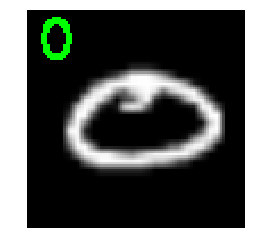

[INFO] Predicted: 7, Actual: 7


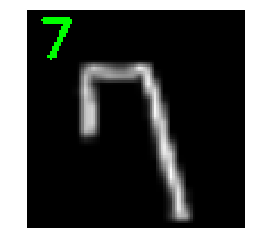

[INFO] Predicted: 7, Actual: 7


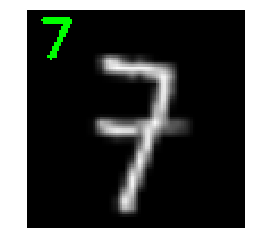

[INFO] Predicted: 2, Actual: 2


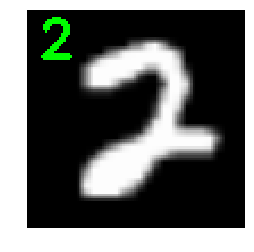

[INFO] Predicted: 9, Actual: 9


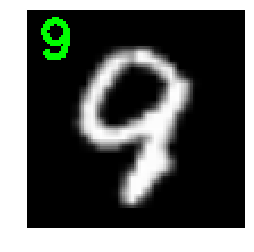

[INFO] Predicted: 1, Actual: 1


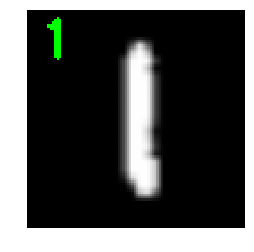

[INFO] Predicted: 9, Actual: 9


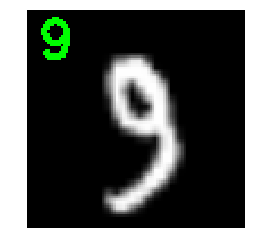

[INFO] Predicted: 7, Actual: 7


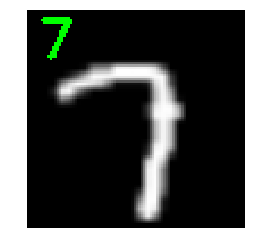

[INFO] Predicted: 2, Actual: 2


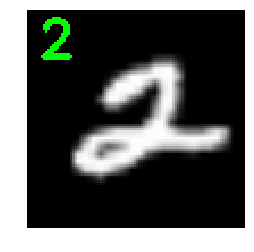

[INFO] Predicted: 8, Actual: 8


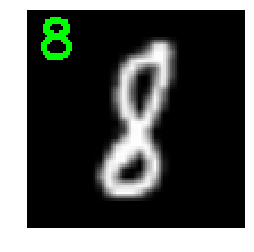

In [7]:
# randomly select a few testing digits
for i in np.random.choice(np.arange(0, len(y_test)), size=(10,)):
    # classify the digit
    # in the original code, x_test[np.newaxis, i] has been done in order
    # match the dimensions of the training sample
    # it should be model.predict(x_test[i, np.newaxis]) instead
    # because the backend Tensorflow expects channel to be the last
    # probs = model.predict(x_test[np.newaxis, i])
    probs = model.predict(x_test[i, np.newaxis])
    
    # finding what digit has the maximum probability
    prediction = probs.argmax(axis=1)
    
    
    # resize the image from a 28 x 28 image to a 96 x 96 image so we
    # can better see it
    # originally there was some issue with this line
    # image = (x_test[i][0] * 255).astype("uint8")
    
    # corrected line
    image = (x_test[i] * 255).astype("uint8")
    # making a 3-channel image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(prediction[0]), (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    # show the image and prediction
    print("[INFO] Predicted: {}, Actual: {}".format(prediction[0], np.argmax(y_test[i])))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    # cv2.imshow("Digit", image)
    # cv2.waitKey(0)
# cv2.destroyAllWindows()